# Text Classification

In [195]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
_
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
_
# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [15, 6]
_
# ML
import pickle
from random import uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, log_loss
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB

In [196]:
%run 00_preprocessing_fuctions.ipynb

### Load in data

In [197]:
df = pd.read_csv('processed_datasets/my_books_PROCESSED.csv')
df = df[['genre', 'filtered_text']]
# df = pd.read_csv('binary_datasets/binary_tdm.csv')
_
df = df.dropna()

In [198]:
df.head()

,genre,filtered_text
0,Fantasy,could survive wild every make sure live see mo...
1,Fantasy,harry potter idea famous raised miserable aunt...
2,Romance,three thing absolutely positive first edward v...
3,Romance,great gatsby scott fitzgerald third stand supr...
4,Fantasy,hole ground lived hobbit nasty dirty wet hole ...


In [199]:
df.shape

(5670, 2)

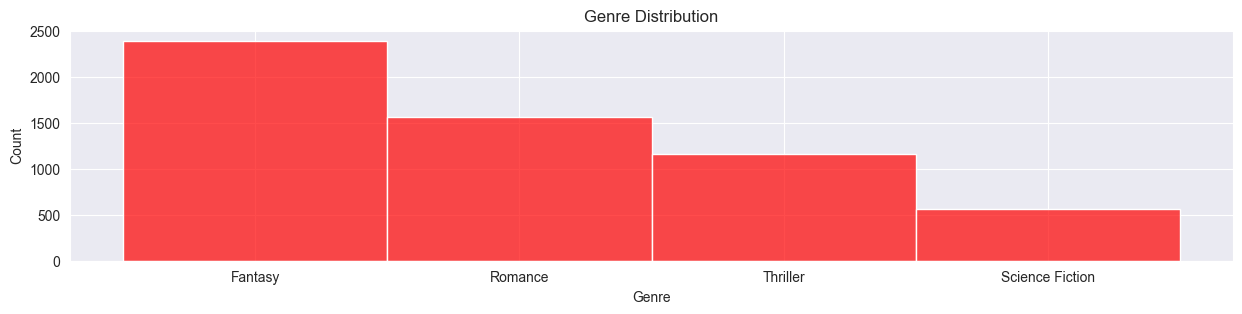

In [200]:
plt.figure(figsize=(15, 3))
plt.title(f"Genre Distribution")
sns.histplot(data=df, x='genre', color='red', alpha=0.7)
plt.xlabel('Genre')
plt.show()

In [201]:
def balance_labels(dataframe: object, label_col_name: str, dist_num: int) -> object:
    """
    Create an even distribution of target labels.
    """
    # Check if distribution split is possible
    lowest_dist = dataframe[label_col_name].value_counts().min()
    if lowest_dist  < dist_num:
        return f"Distribution split of {dist_num} not possible. Minimum split available: {lowest_dist}"

    # For personal testing
    new_dataframes = []
    for curr_label in dataframe[label_col_name].unique():
        temp_df = dataframe[dataframe[label_col_name] == curr_label].sample(lowest_dist)
        new_dataframes.append(temp_df)

    # Concat new dataframes
    return pd.concat(new_dataframes, axis=0)

In [202]:
# df = balance_labels(df, 'genre', 558)
# _
# print(df.shape, '\n')
# df.sample(10)

### Train, test, split

In [203]:
# Encode target labels
le = LabelEncoder()
df['genres_encoded'] = le.fit_transform(df['genre'])

In [204]:
X, y = df['filtered_text'], df['genres_encoded'] # Independent features, target label

In [205]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.30, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.20, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3969,)
y_train shape: (3969,)
X_cv shape: (1360,)
y_cv shape: (1360,)
X_test shape: (341,)
y_test shape: (341,)


### TD-iDF

In [206]:
vectorizer = TfidfVectorizer(
    max_df=0.3, 
    min_df=2, 
    stop_words='english', 
    lowercase=True, 
    use_idf=True, 
    norm='l2', 
    smooth_idf=True,
    strip_accents='unicode'
)
td_idf = vectorizer.fit_transform(X_train)

columns = vectorizer.get_feature_names_out()
values = td_idf.toarray()
X_train_tdm = pd.DataFrame(values, columns=columns)
_
n_rows, n_cols = X_train_tdm.shape
print(f"Rows: {n_rows}, columns: {n_cols}\n")
X_train_tdm.head()

Rows: 3969, columns: 14519



,aang,aaron,aaronovitch,abandon,abandoned,abandoning,abandonment,abarat,abbey,abbott,...,zombie,zone,zoo,zookeeper,zora,zorro,zuko,zum,zurich,zuruck
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.067652,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
# final_df = df.iloc[y_train.index][['genres_encoded']].reset_index(drop=True).join(tdm, how='right')
# final_df = final_df.rename(columns={'genres_encoded': 'genre'})  # Rename genre column for consistency
# _
# n_rows, n_cols = final_df.shape
# print(f"Rows: {n_rows}, columns: {n_cols}\n")
# final_df.head(3)

### Training

In [208]:
models = {'NB': MultinomialNB(), 'CompNB': ComplementNB(), 'BernoulliNB': BernoulliNB()}
X_cv_tdm = tdm_converter(vectorizer, X_cv)
_
# Get baseline metrics for each model
for name, model in models.items():
    model.fit(X_train_tdm, y_train)
    # Preprocess X_cv data
    y_pred = model.predict(X_cv_tdm)
    y_probas = model.predict_proba(X_cv_tdm)
    display_metrics(name, y_cv, y_pred, y_probas)
    print(f"-------------------------------------")

Model: NB
Accuracy score: 0.675
Recall score: 0.5153372255810172
Precision score: 0.5947374886438697
f1 score: 0.5165906468931075
Log loss 0.8719314313115955
ROC AUC: 0.9238429648114165
-------------------------------------
Model: CompNB
Accuracy score: 0.7970588235294118
Recall score: 0.7360212004082545
Precision score: 0.8182618519451845
f1 score: 0.7621044654831167
Log loss 0.9088355920295572
ROC AUC: 0.9452942415371142
-------------------------------------
Model: BernoulliNB
Accuracy score: 0.7375
Recall score: 0.6324405291226526
Precision score: 0.7847105980048811
f1 score: 0.6612338785571759
Log loss 2.6442808082691527
ROC AUC: 0.9223888425746521
-------------------------------------


### Parameter tuning

In [209]:
model_params = {
    # NB parameters
    'NB': {
        'alpha': set([uniform(0.0, 1.0) for _ in range(200)]),
    },
    # Complement NB parameters
    'CompNB': {
        'alpha': set([uniform(0.2, 0.7) for _ in range(200)]),
    },
    # Bernoull NB parameter
    'BernoulliNB': {
        'alpha': set([uniform(0.0, 2.0) for _ in range(200)])
    }
}

In [210]:
grid_results = {
    'model': [],
    'alpha': [],
    'accuracy_score': [], 
    'recall_score': [], 
    'precision_score': [], 
    'f1_score': [], 
    'log_loss': [], 
    'roc_auc': []
}
_
for name, model in models.items():
    print(f"Fitting {name}...")
    for alpha_val in tqdm(model_params[name]['alpha'], total=len(model_params[name]['alpha'])):
        if name == 'NB':
            test_model = MultinomialNB(alpha=alpha_val, force_alpha=True)
        elif name == 'CompNB':
            test_model = ComplementNB(alpha=alpha_val, force_alpha=True)
        else:
            test_model = BernoulliNB(alpha=alpha_val, force_alpha=True)

        # Fit model with current parameters
        test_model.fit(X_train_tdm, y_train)

        # Run metrics on test set
        y_pred = test_model.predict(X_cv_tdm)
        y_probas = test_model.predict_proba(X_cv_tdm)
    
        acc_score = accuracy_score(y_cv, y_pred)
        re_score = recall_score(y_cv, y_pred, average='macro')
        prec_score = precision_score(y_cv, y_pred, average='macro')
        f1 = f1_score(y_cv, y_pred, average='macro')
        log_loss_val = log_loss(y_cv, y_probas, labels=y_cv)
        roc_auc_val = roc_auc_score(y_cv, y_probas, multi_class='ovr')
    
        # Store results in data dict
        grid_results['model'].append(name)
        grid_results['alpha'].append(alpha_val)
        grid_results['accuracy_score'].append(acc_score)
        grid_results['recall_score'].append(re_score)
        grid_results['f1_score'].append(f1)
        grid_results['precision_score'].append(prec_score)
        grid_results['log_loss'].append(log_loss_val)
        grid_results['roc_auc'].append(roc_auc_val)
_
print(f"\nFitting complete!")

Fitting NB...


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting CompNB...


  0%|          | 0/200 [00:00<?, ?it/s]

Fitting BernoulliNB...


  0%|          | 0/200 [00:00<?, ?it/s]


Fitting complete!


### Training results

In [211]:
# View results
results = pd.DataFrame(grid_results).sort_values(['f1_score'], ascending=False)
results.head()

# PREVIOUS TESTING RESULTS:
# Comp: 1.068941
# Comp: 0.349623
# Comp: 0.417082 — BEST TEST

,model,alpha,accuracy_score,recall_score,precision_score,f1_score,log_loss,roc_auc
293,CompNB,0.516052,0.805147,0.759168,0.815754,0.779125,0.846212,0.948987
246,CompNB,0.467671,0.804412,0.759487,0.814227,0.778622,0.837626,0.949229
371,CompNB,0.274584,0.802941,0.762845,0.807951,0.778200,0.794422,0.949648
351,CompNB,0.457259,0.804412,0.759709,0.812257,0.778138,0.835688,0.949282
244,CompNB,0.461471,0.804412,0.759487,0.812280,0.778074,0.836476,0.949275


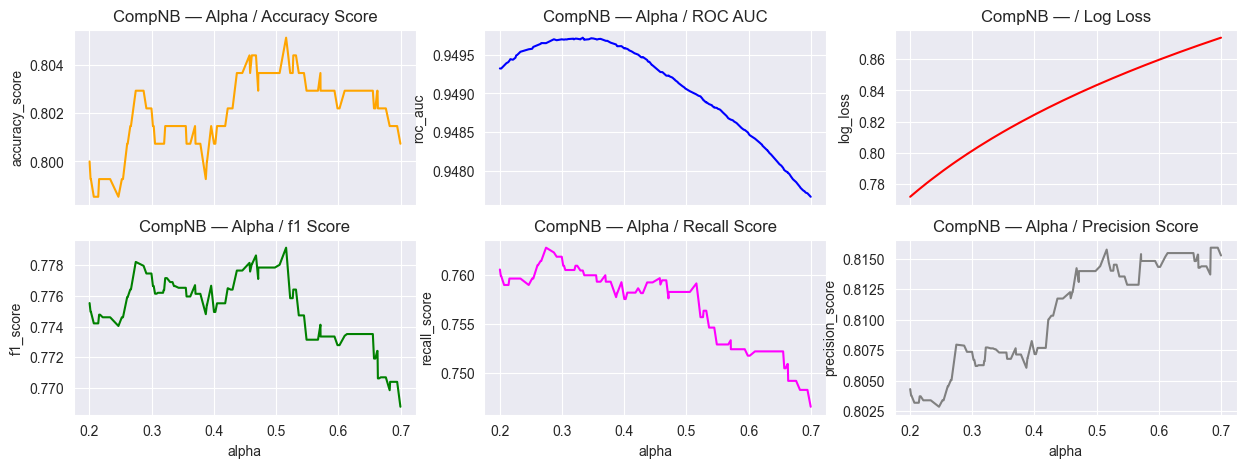

----------------------------------------


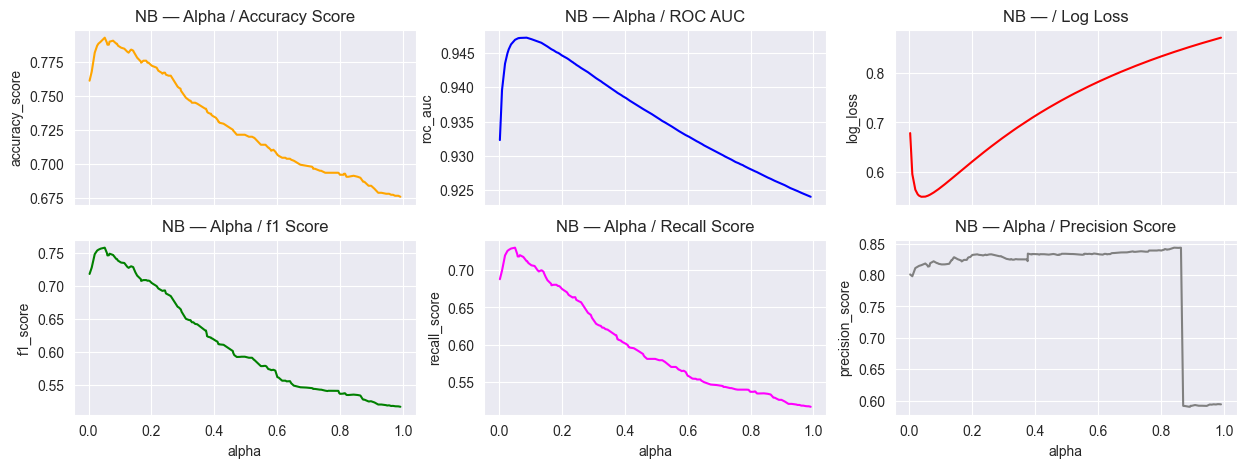

----------------------------------------


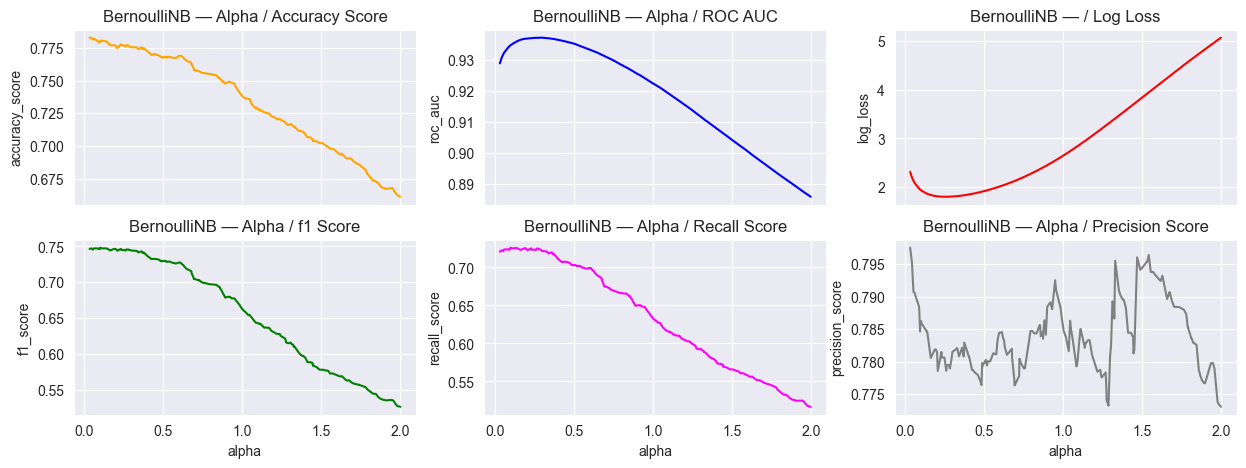

----------------------------------------


In [212]:
def display_results(dataframe, model_name):
    f, axs = plt.subplots(2, 3, figsize=(15, 5), sharex=True)
    sns.lineplot(data=dataframe, x='alpha', y='accuracy_score', color='orange', ax=axs[0][0])
    sns.lineplot(data=dataframe, x='alpha', y='roc_auc', color='blue', ax=axs[0][1])
    sns.lineplot(data=dataframe, x='alpha', y='log_loss', color='red', ax=axs[0][2])
    sns.lineplot(data=dataframe, x='alpha', y='f1_score', color='green', ax=axs[1][0])
    sns.lineplot(data=dataframe, x='alpha', y='recall_score', color='magenta', ax=axs[1][1])
    sns.lineplot(data=dataframe, x='alpha', y='precision_score', color='grey', ax=axs[1][2])
    axs[0][0].set_title(f"{model_name} — Alpha / Accuracy Score")
    axs[0][1].set_title(f"{model_name} — Alpha / ROC AUC")
    axs[0][2].set_title(f"{model_name} — / Log Loss")
    axs[1][0].set_title(f"{model_name} — Alpha / f1 Score")
    axs[1][1].set_title(f"{model_name} — Alpha / Recall Score")
    axs[1][2].set_title(f"{model_name} — Alpha / Precision Score")
    plt.show()

_
for model_name in results['model'].unique():
    temp_df = results[results['model'] == model_name]
    display_results(temp_df, model_name)
    print(f"----------------------------------------")

### Testing

In [213]:
# Concat CV and Train data
X_train_cv = pd.concat([X_train, X_cv], axis=0)
y_train_cv = pd.concat([y_train, y_cv], axis=0)
_
# X_train_cv_tdm = tdm_converter(vectorizer, X_train_cv)
X_td_idf = vectorizer.fit_transform(X_train_cv)
columns = vectorizer.get_feature_names_out()
values = X_td_idf.toarray()
X_train_cv_tdm = pd.DataFrame(values, columns=columns)

In [214]:
# Main classifier
clf = ComplementNB(alpha=results['alpha'].iloc[0], force_alpha=True)
clf.fit(X_train_cv_tdm, y_train_cv)

ComplementNB(alpha=0.5160523954755388)

In [215]:
X_test_tdm = tdm_converter(vectorizer, X_test)
y_pred = clf.predict(X_test_tdm)
y_probas = clf.predict_proba(X_test_tdm)
_
display_metrics(clf.__class__.__name__, y_test, y_pred, y_probas)

Model: ComplementNB
Accuracy score: 0.8475073313782991
Recall score: 0.8356522433534816
Precision score: 0.8390551657793037
f1 score: 0.835431470289126
Log loss 0.7688113219247403
ROC AUC: 0.9703053943900306


### Save models

In [138]:
# Save models / load models
def save_model(model: object, file_name: str):
    """
    Converts current model as a Pickle file for later use.
    """
    with open(f"models/{file_name}", 'wb') as f:
        pickle.dump(model, f)

_
save_model(le, 'label_encoder.pkl')
save_model(vectorizer, 'vectorizer.pkl')
save_model(clf, 'classifier.pkl')